1- Consider a limit-order-book (LOB). At the LOB, we define the volume imbalance measure $\rho_t$ as 
\begin{equation*}
\rho_t = \dfrac{V_t^b - V_t^a}{V_t^b + V_t^a} \in [ -1,1]
\end{equation*}
where $V_t^b $ and  $V_t^a $  are the volumes at time $t$ of limit orders outstanding at the best bid and the best ask price levels, consecutively. 

Further, let $S_t$ denote the state of the book at time $t$ and defined as 
$$
S_t = 
\begin{array}{llr}
\text{sell} & \text{if}&  -1 \leq  \rho_t < -\dfrac{1}{3} \\
&&\\
\text{neutral}  & \text{if}&  - \dfrac{1}{3} \leq \rho_t \leq \dfrac{1}{3} \\
&&\\
\text{buy} & \text{if}&  \frac{1}{3} <   \rho_t \leq 1 \\
\end{array} 
$$

Find the distribution of the market sell orders and market buy orders among the states; ie, number of total market sell and buy orders for each state (sell, neutral, and buy states) for the whole day. 

In [300]:
import pandas as pd
raw_df = pd.read_json('/Users/hrn/Downloads/lob74196.json')

# Function that calculates the state of the book (Buy, Neutral, or Sell)
# given the best bid and ask levels. In deed, we feed the whole dataframe row to the function 

def calc_state(row, th=1/3):
    q_best_ask = row.Ask[0][1]
    q_best_bid = row.Bid[0][1]
    rho = (q_best_bid - q_best_ask) / (q_best_ask + q_best_bid)
    if rho < -th:
        ret = 'S'
    elif rho < th:
        ret = 'N'
    else:
        ret = 'B'
    # print(rho, row.Bid[0], row.Ask[0])
    return ret

# The function below updates the total market order sizes in the relevant row and column
# of the result matrix
def add_to_mat(df, r, c, q):
    df[r][c] +=q

# This function returns the market order (mo) side of execution side
# If execution is on Buy side then it is a Sell market order and vice versa.
# Remember that itch data reports the execution side.
def exec_to_mo(side):
    if side=='S':
        return 'B'
    else:
        return 'S'

In [297]:
# The iterator that will iterate through the rows of the main Dataframe
iter_raw = raw_df.itertuples()

'''
We initialize the following result matrix (in the form of a pandas Dataframe):

       B    S
 ----------------
  B |  0    0
  N |  0    0
  S |  0    0
  

The rows are states of the order book: B(uy), N(eutral), S(ell)
The columns are the side of the market orders
Therefore, the cells are the total number of market orders for the state and the side.
'''
res_mat = pd.DataFrame([[0] * 2] * 3,
                  index= ['B', 'N', 'S'],
                  columns=list('BS'))

# The loop iterates through the rows of the main Dataframe.
# It updates the result matrix if there is any E(xecution) message in the row.
for i, row in enumerate(iter_raw):
    if i == 0:
        prev_row = row
        continue
    this_m = row.Messages
    
    for message in this_m:
        if message[0]=='E':     # and message[3]>1000:
            exec_side = message[1]
            mo_side = exec_to_mo(exec_side)
            q = message[2]
            state = calc_state(prev_row, 2/3)
            # print(side, q, state)
            add_to_mat(res_mat, mo_side, state, q)
    prev_row = row

In [298]:
# We just return the result matrix
res_mat

,B,S
B,11268,6147
N,109521,97830
S,5868,18162


2- Find the distribution of the midprice change 10 miliseconds after the arrival of a sell market order among the states; ie, the number of ticks changed after arrival of a sell market order for each state (sell, neutral, and buy states).

(8150, 2)


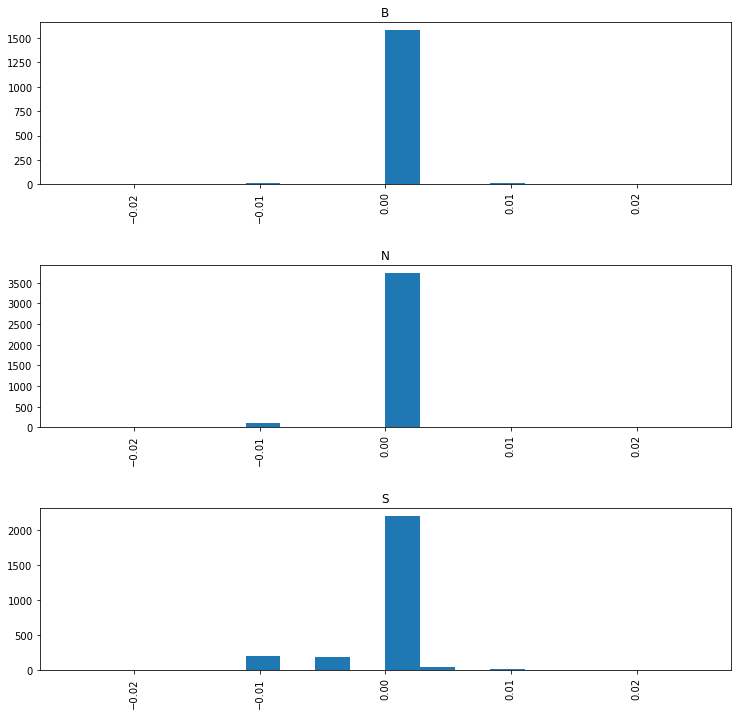

In [328]:
%matplotlib inline
# from scipy import stats
import matplotlib.pyplot as plt
iter_raw = raw_df.itertuples()

# que is the queue vector. An item is added when a market sell order occurs 
# and the same item is popped >=10 ms later after the information is processed.
# It holds the tuples (Timestamp, mid price, the state of LOB in the previous row)
# observed for all sell market orders
que = []
res = [] # The result vector conatining (state, mid price diff) tuples

for i, row in enumerate(iter_raw):
    this_m = row.Messages
    
    if i <1: # Skip the first row 
        prev_row = row
        continue
    
    for message in this_m:
        if message[0:2]==['E','B']:
            b_mid_price = (row.Ask[0][0] + row.Bid[0][0] ) * 0.5
            que.append((row.TimeStamp, b_mid_price, calc_state(prev_row,1/3)))
            break
            
    while que and row.TimeStamp - que[0][0] >= np.timedelta64(10,'ms'):
        f_mid_price = (row.Ask[0][0] + row.Bid[0][0] ) * 0.5
        state = que[0][2]
        diff = f_mid_price - que[0][1]
        res.append((state, diff))
        que.pop(0)
    prev_row = row

df_res = pd.DataFrame(res,columns = ['state', 'dif'])
# print(df_res.shape)
df_res.sort_values(by=['state'], inplace=True)

df_res.hist(by='state',  range=(-0.025, 0.025),bins=18, layout=(3,1), figsize=(12,12))
pass
# print(df_res.head())
# mat = df_res.groupby('state').apply(lambda x: np.percentile(x.dif,[0,20,50,90,99,100]).round(4) )

# mat = df_res.groupby('state').count()
# pd.options.display.float_format = '${:,.2f}'.format
# np.set_printoptions(precision=1)
# print(mat)
# df_res.groupby('state').apply(lambda x: plt.hist(x.dif, bins=18,range=(-0.02, 0.02),
#                                                  histtype='step',align='left' ) )
# fig = plt.gcf()
# fig.set_size_inches(15,5)
# plt.legend(('', 'B', 'N', 'S'))
# 